In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
from PIL import Image

import torchvision.datasets as dset
import torchvision.transforms as T
import chest_xray_code.data.xrays as preprocess_dataset
import chest_xray_code.data.raw_reports as utils
import os
import torch.nn.functional as F
from models.NewConvModel import NewConvNet 
from models.TestConvNet import TestConvNet
from models.OscarConvModel import OscarNet as ConvNet16
from loaders.XrayLoader import XrayLoader
from loaders.XrayLoader256 import XrayLoader256
from loaders.BloodCellLoader import BloodCellLoader
from loaders.BloodCellLoader256 import BloodCellLoader256
from loaders.MuseumLoader import MuseumLoader
from loaders.MuseumLoader256 import MuseumLoader256

import numpy as np

In [2]:
xray_set = XrayLoader(
    root='chest_xray_code/data/test_set',
    preload=False, transform=transforms.ToTensor(),
)
xray_loader = DataLoader(xray_set, batch_size=20, shuffle=False, num_workers=32)

xray_set256 = XrayLoader256(
    root='chest_xray_code/data/test_set',
    preload=False, transform=transforms.ToTensor(),
)
xray_loader256 = DataLoader(xray_set256, batch_size=20, shuffle=False, num_workers=32)


print(len(xray_set))
print(len(xray_set256))

245
245


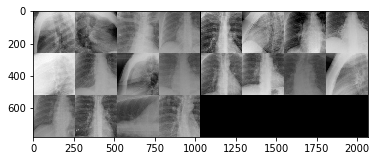

In [3]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    img = img.numpy()
    
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 2 * (img - img_min) / (img_max - img_min)
    
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.savefig('compressed.png')
    
    # functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('original.png')

# get some random training images
dataiter = iter(xray_loader256)
images = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [4]:
class ConvNet16(nn.Module):
    def __init__(self,channels,size):
        super().__init__()

        self.conv_1_compress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_compress = nn.ReLU()
        
        self.conv_2_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_compress = nn.BatchNorm2d(size)
        self.relu_2_compress = nn.ReLU()
        
        self.conv_3_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_3_compress = nn.BatchNorm2d(size)
        self.relu_3_compress = nn.ReLU()
        
        self.conv_4_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_compress = nn.BatchNorm2d(size)
        self.relu_4_compress = nn.ReLU()
        
        self.conv_5_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_compress = nn.BatchNorm2d(size)
        self.relu_5_compress = nn.ReLU()
        
        self.conv_6_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_6_compress = nn.BatchNorm2d(size)
        self.relu_6_compress = nn.ReLU()

        self.conv_downsize_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_downsize_compress = nn.BatchNorm2d(size)
        self.relu_downsize_compress = nn.ReLU()
        
        self.conv_7_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_compress = nn.BatchNorm2d(size)
        self.relu_7_compress = nn.ReLU()
        
        self.conv_8_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_8_compress = nn.BatchNorm2d(size)
        self.relu_8_compress = nn.ReLU()
        
        self.conv_9_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_compress = nn.BatchNorm2d(size)
        self.relu_9_compress = nn.ReLU()
        
        self.conv_10_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_10_compress = nn.BatchNorm2d(size)
        self.relu_10_compress = nn.ReLU()
        
        self.conv_11_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_11_compress = nn.BatchNorm2d(size)
        self.relu_11_compress = nn.ReLU()
        
        self.conv_12_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_12_compress = nn.BatchNorm2d(size)
        self.relu_12_compress = nn.ReLU()
        
        self.conv_13_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_13_compress = nn.BatchNorm2d(size)
        self.relu_13_compress = nn.ReLU()
        
        
        self.conv_compress_final = nn.Conv2d(size, channels, kernel_size=3,stride=1,padding=1,bias=True)
        
        self.upscaling = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_1_decompress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_decompress = nn.ReLU()
        
        self.conv_2_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_decompress = nn.BatchNorm2d(size)
        self.relu_2_decompress = nn.ReLU()
        
        self.conv_3_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_decompress = nn.BatchNorm2d(size)
        self.relu_3_decompress = nn.ReLU()
        
        self.conv_4_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_decompress = nn.BatchNorm2d(size)
        self.relu_4_decompress = nn.ReLU()
        
        self.upscaling2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_5_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_decompress = nn.BatchNorm2d(size)
        self.relu_5_decompress = nn.ReLU()
        
        self.conv_6_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_6_decompress = nn.BatchNorm2d(size)
        self.relu_6_decompress = nn.ReLU()
        
        self.conv_7_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_decompress = nn.BatchNorm2d(size)
        self.relu_7_decompress = nn.ReLU()
        
        self.conv_8_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_8_decompress = nn.BatchNorm2d(size)
        self.relu_8_decompress = nn.ReLU()
        
        self.upscaling3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_9_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_decompress = nn.BatchNorm2d(size)
        self.relu_9_decompress = nn.ReLU()
        
        self.conv_10_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_10_decompress = nn.BatchNorm2d(size)
        self.relu_10_decompress = nn.ReLU()
        
        self.conv_11_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_11_decompress = nn.BatchNorm2d(size)
        self.relu_11_decompress = nn.ReLU()
        
        self.conv_12_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_12_decompress = nn.BatchNorm2d(size)
        self.relu_12_decompress = nn.ReLU()
        
        self.upscaling4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_13_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_13_decompress = nn.BatchNorm2d(size)
        self.relu_13_decompress = nn.ReLU()
        
        self.conv_14_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_14_decompress = nn.BatchNorm2d(size)
        self.relu_14_decompress = nn.ReLU()
        
        self.conv_15_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_15_decompress = nn.BatchNorm2d(size)
        self.relu_15_decompress = nn.ReLU()
        
        self.conv_16_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_16_decompress = nn.BatchNorm2d(size)
        self.relu_16_decompress = nn.ReLU()
        
        self.conv_17_decompress = nn.Conv2d(size, 3, kernel_size=3,stride=1,padding=1,bias=True)
        

    def forward(self, x):
        scores = None
        model = torch.nn.Sequential( 
            
            self.conv_1_compress,
            self.relu_1_compress,
        
            self.conv_2_compress,
            self.batchnorm_2_compress,
            self.relu_2_compress,
            
            self.conv_3_compress,
            self.batchnorm_3_compress,
            self.relu_3_compress,
            
            self.conv_4_compress,
            self.batchnorm_4_compress,
            self.relu_4_compress,
            
            self.conv_5_compress,
            self.batchnorm_5_compress,
            self.relu_5_compress,
            
            self.conv_6_compress,
            self.batchnorm_6_compress,
            self.relu_6_compress,
            
            self.conv_downsize_compress,
            self.batchnorm_downsize_compress,
            self.relu_downsize_compress,
            
            self.conv_7_compress,
            self.batchnorm_7_compress,
            self.relu_7_compress,
            
            self.conv_8_compress,
            self.batchnorm_8_compress,
            self.relu_8_compress,
            
            self.conv_9_compress,
            self.batchnorm_9_compress,
            self.relu_9_compress,
            
            self.conv_10_compress,
            self.batchnorm_10_compress,
            self.relu_10_compress,
            
            self.conv_11_compress,
            self.batchnorm_11_compress,
            self.relu_11_compress,
            
            self.conv_12_compress,
            self.batchnorm_12_compress,
            self.relu_12_compress,
            
            self.conv_13_compress,
            self.batchnorm_13_compress,
            self.relu_13_compress,
            
            self.conv_compress_final,
        
            self.upscaling,
            
            self.conv_1_decompress,
            self.relu_1_decompress,
        
            self.conv_2_decompress,
            self.batchnorm_2_decompress,
            self.relu_2_decompress,
            
            self.conv_3_decompress,
            self.batchnorm_3_decompress,
            self.relu_3_decompress,
            
            self.conv_4_decompress,
            self.batchnorm_4_decompress,
            self.relu_4_decompress,
            
            self.upscaling2,
            
            self.conv_5_decompress,
            self.batchnorm_5_decompress,
            self.relu_5_decompress,
            
            self.conv_6_decompress,
            self.batchnorm_6_decompress,
            self.relu_6_decompress,
            
            self.conv_7_decompress,
            self.batchnorm_7_decompress,
            self.relu_7_decompress,
            
            self.conv_8_decompress,
            self.batchnorm_8_decompress,
            self.relu_8_decompress,
            
            self.upscaling3,
            
            self.conv_9_decompress,
            self.batchnorm_9_decompress,
            self.relu_9_decompress,
            
            self.conv_10_decompress,
            self.batchnorm_10_decompress,
            self.relu_10_decompress,
            
            self.conv_11_decompress,
            self.batchnorm_11_decompress,
            self.relu_11_decompress,
            
            self.conv_12_decompress,
            self.batchnorm_12_decompress,
            self.relu_12_decompress,
            
            self.upscaling4,
        
            self.conv_13_decompress,
            self.batchnorm_13_decompress,
            self.relu_13_decompress,
            
            self.conv_14_decompress,
            self.batchnorm_14_decompress,
            self.relu_14_decompress,
            
            self.conv_15_decompress,
            self.batchnorm_15_decompress,
            self.relu_15_decompress,
            
            self.conv_16_decompress,
            self.batchnorm_16_decompress,
            self.relu_16_decompress,
            
            self.conv_17_decompress

            
        ).to(device)
        scores = model(x)
        return scores

In [5]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    #dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 5


# Architecture

In [6]:
def train(model, epoch, log_interval=100):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    model = torch.nn.DataParallel(model)
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data) in enumerate(trainset_loader):
            data = data.to(device=device, dtype=dtype)
            optimizer.zero_grad()
            #print(data.shape)
            reconstruction = model(data)
            loss_function = nn.MSELoss(size_average=True)
            loss = loss_function(reconstruction, data)
            loss.backward()
            optimizer.step()
        if ep % print_every == 0:
            print('Iteration %d, loss = %.4f' % (ep, loss.item()))
            print()

def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in testset_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))
    

In [7]:
channels = 3
size = 32
model100 = torch.load('trained_models/xraymodelV2.pt')
model50 = NewConvNet(channels,size,device)
model50.load_state_dict(torch.load('trained_models/new_xray.pt'))
model16 = ConvNet16(channels,size)
model16 = torch.load('xray16.pt')

/home/shared/anaconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.TestConvNet.TestConvNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type ConvNet16. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Visualize the Compressed images 

In [11]:
#model = torch.load('trained_models/xraymodelV2.pt')

plt.close("all")


all_images = [[],[],[],[]]

def prep(img):
    img = img.numpy()
    if True:
        img_max, img_min = np.max(img), np.min(img)
        img = (img - img_min) / (img_max - img_min) 
    return np.transpose(img, (1, 2, 0)) 
    
def save_compressed(self,input,output):
    #for i in range(1):
    img = output.cpu().detach()
    for i in range(img.shape[0]):
        individual_img = img[i]
        all_images[1].append(prep(individual_img))

def save_original_and_jpeg(data,path,q):
    img = data.cpu().detach()

    for i in range(img.shape[0]):
        individual_img = img[i]
        individual_img = individual_img.numpy()
        individual_img = np.transpose(individual_img, (1, 2, 0))
        all_images[0].append(individual_img) #append original

        rescaled = (255.0 * individual_img)
        rescaled = rescaled.astype('uint8')
        
        PIL_img = Image.fromarray(rescaled)
        jpeg_filename =  path +"/"+ str(i) + "jpeg.jpeg"
        PIL_img.save(jpeg_filename,"JPEG",quality=q)
     
        jpeg_compressed = Image.open(jpeg_filename)
        jpeg_compressed = np.asarray(jpeg_compressed)
        #jpeg_compressed = np.transpose(jpeg_compressed,(1,2,0))
        all_images[3].append(jpeg_compressed) #append jpeg

def save_reconstructed(r):
    r = r.cpu().detach()
    
    for i in range(r.shape[0]):
        individual_img = r[i]
        individual_img = individual_img.numpy()
        individual_img = np.transpose(individual_img, (1, 2, 0))
        individual_img = np.clip(individual_img,0,1)
        all_images[2].append(individual_img)
        

def save_original(data):
    img = data.cpu().detach()
    
    for i in range(img.shape[0]):
        individual_img = img[i]
        individual_img = individual_img.numpy()
        individual_img = np.transpose(individual_img, (1, 2, 0))
        all_images[0].append(individual_img)


#hook.remove()
def save_from_numpy(img,file_path):
    img = 255.0 * img
    img = img.astype('uint8')
    if img.shape[2] != 3:
        img = np.transpose(img,(1,2,0))
    img = Image.fromarray(img)
    img.save(file_path)



def visualize(dataset_loader,model,file_path,quality):
    i = 0
    print("hello")
    
    hook = model.conv_compress_final.register_forward_hook(save_compressed)
    
    
    reconstruction = None
    print("iterating through dataset")
    for data in dataset_loader:
        with torch.no_grad():
            if i > 0: break
            data = data.to(device)
            save_original_and_jpeg(data,file_path,quality)
            reconstruction = model(data)
            save_reconstructed(reconstruction)
            i+=1
            
    avg_psnr_rec = 0.0
    avg_psnr_jpeg = 0.0

    for i in range(20):
        plt.figure()
        org = all_images[0][i]
        print(org.shape)
        save_from_numpy(org,file_path+"/"+str(i)+"org.png")
        plt.subplot(1, 4, 1)
        plt.axis('off')
        #imshow_noax(org, normalize=False)
        plt.imshow(org)
        plt.title('Original')
        plt.subplot(1, 4, 2)
        com = all_images[1][i]
        plt.imshow(com)
        save_from_numpy(com,file_path+"/"+str(i)+"com.png")
        print(com.shape)
        #imshow_noax(rec, normalize=False)
        plt.title('Compressed')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        recon = all_images[2][i]
        print(recon.shape)
        save_from_numpy(recon,file_path+"/"+str(i)+"recon.png")
        plt.axis('off')
        plt.imshow(recon)
        plt.title('Reconstructed')
        plt.subplot(1, 4, 4)
        jpg = all_images[3][i]
        #save_from_numpy(jpg,file_path+"/"+str(i)+"jpg.png")
        print(jpg.shape)
        plt.axis('off')
        plt.imshow(jpg)
        plt.title('JPG')
        plt.show()
        
        mserec = np.sum((org - recon)**2) / (org.shape[0]**2)
        psnr = -10*np.log10(mserec)
        avg_psnr_rec += psnr
        print('image%s reconstruction PSNR: %s' % (i,psnr))
        msejpeg = np.sum((org - jpg/255.0)**2) / (org.shape[0]**2)
        psnr = -10*np.log10(msejpeg)
        avg_psnr_jpeg += psnr
        print('image%s jpeg PSNR: %s' % (i,psnr))
        
    avg_psnr_rec = avg_psnr_rec/20
    avg_psnr_jpeg = avg_psnr_jpeg/20
    print('')
    print('Average reconstruction PSNR: %s' % avg_psnr_rec)
    print('Average JPEG PSNR: %s' % avg_psnr_jpeg)   
    print('')
        



Visualize the Reconstructed Images

hello
iterating through dataset
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


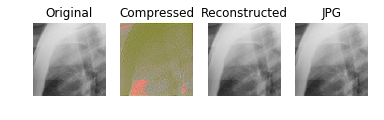

image0 reconstruction PSNR: 37.512431446848936
image0 jpeg PSNR: 53.73471494195955
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


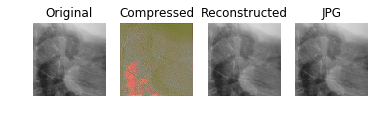

image1 reconstruction PSNR: 37.07783649044411
image1 jpeg PSNR: 53.64335413698912
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


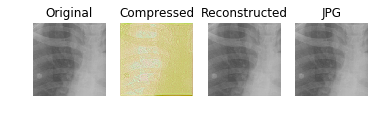

image2 reconstruction PSNR: 41.217731956950104
image2 jpeg PSNR: 53.82441143961458
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


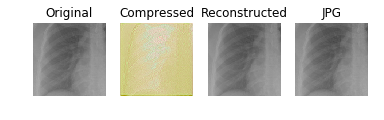

image3 reconstruction PSNR: 41.69748370884783
image3 jpeg PSNR: 54.13104084700941
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


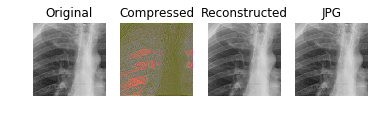

image4 reconstruction PSNR: 34.48781124577315
image4 jpeg PSNR: 53.7655998948124
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


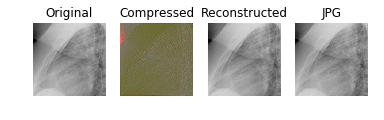

image5 reconstruction PSNR: 36.652336512100035
image5 jpeg PSNR: 53.76440828386415
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


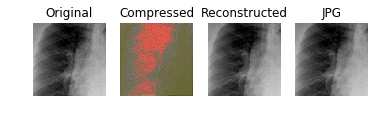

image6 reconstruction PSNR: 34.846142268881465
image6 jpeg PSNR: 53.91970241933673
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


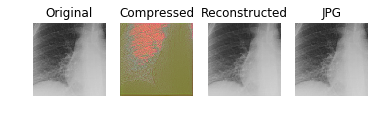

image7 reconstruction PSNR: 37.04685248154289
image7 jpeg PSNR: 54.35182676381893
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


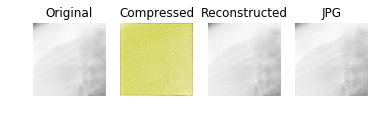

image8 reconstruction PSNR: 40.476748162619685
image8 jpeg PSNR: 53.78831002107496
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


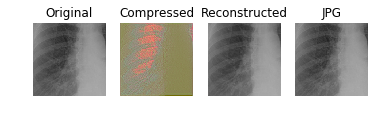

image9 reconstruction PSNR: 37.95034718807124
image9 jpeg PSNR: 54.03485314894259
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


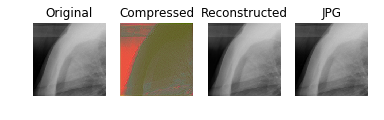

image10 reconstruction PSNR: 38.23120693638924
image10 jpeg PSNR: 53.801511347609235
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


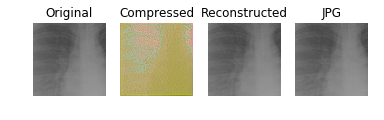

image11 reconstruction PSNR: 42.11202668633385
image11 jpeg PSNR: 54.412277603979824
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


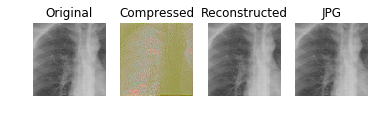

image12 reconstruction PSNR: 38.62892938794176
image12 jpeg PSNR: 53.75250604837228
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


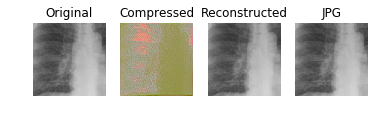

image13 reconstruction PSNR: 37.601876663369815
image13 jpeg PSNR: 53.80151140398681
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


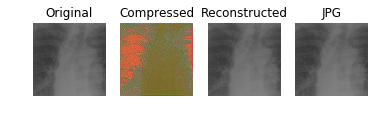

image14 reconstruction PSNR: 40.06269078522386
image14 jpeg PSNR: 54.45537958430612
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


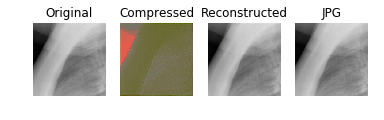

image15 reconstruction PSNR: 40.11282869434919
image15 jpeg PSNR: 53.79310601418828
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


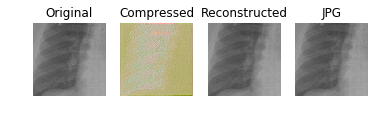

image16 reconstruction PSNR: 40.481409953791555
image16 jpeg PSNR: 54.09102388043094
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


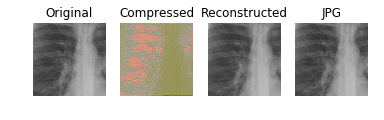

image17 reconstruction PSNR: 36.840197144450016
image17 jpeg PSNR: 53.918466740312255
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


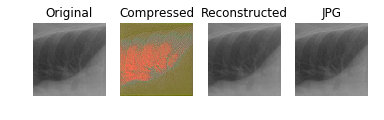

image18 reconstruction PSNR: 39.98408396146863
image18 jpeg PSNR: 53.97064311317386
(200, 200, 3)
(100, 100, 3)
(200, 200, 3)
(200, 200, 3)


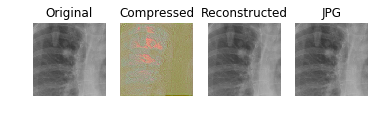

image19 reconstruction PSNR: 39.15092964441374
image19 jpeg PSNR: 53.69348224636009

Average reconstruction PSNR: 38.60859506599055
Average JPEG PSNR: 53.93240649400711

hello
iterating through dataset
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


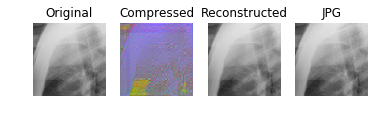

image0 reconstruction PSNR: 33.43705386080055
image0 jpeg PSNR: 44.04081912919388
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


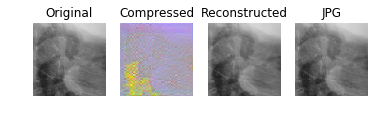

image1 reconstruction PSNR: 32.253590220807915
image1 jpeg PSNR: 43.72360128996881
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


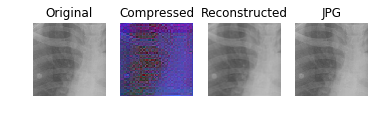

image2 reconstruction PSNR: 35.19543802105822
image2 jpeg PSNR: 45.57265353042788
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


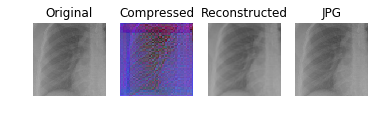

image3 reconstruction PSNR: 35.22865767975444
image3 jpeg PSNR: 45.00665109352886
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


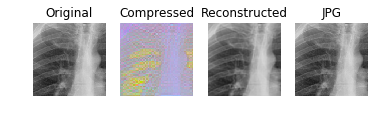

image4 reconstruction PSNR: 31.21084371840485
image4 jpeg PSNR: 41.05063379313557
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


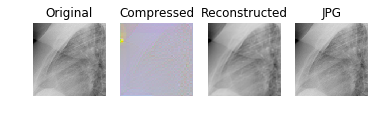

image5 reconstruction PSNR: 32.18127973597873
image5 jpeg PSNR: 41.51537496436646
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


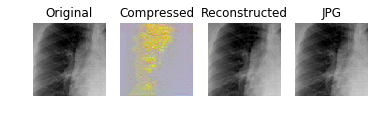

image6 reconstruction PSNR: 31.347484095989827
image6 jpeg PSNR: 41.554748414108516
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


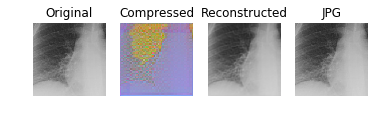

image7 reconstruction PSNR: 33.92811849141497
image7 jpeg PSNR: 43.65089464027505
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


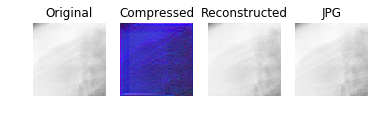

image8 reconstruction PSNR: 36.11306366394427
image8 jpeg PSNR: 45.31240571105815
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


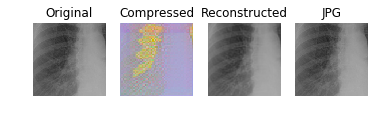

image9 reconstruction PSNR: 34.22652531431577
image9 jpeg PSNR: 42.954062901185715
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


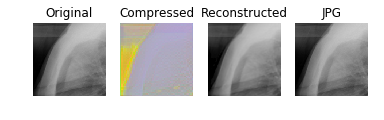

image10 reconstruction PSNR: 33.762702557707144
image10 jpeg PSNR: 45.27798837971007
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


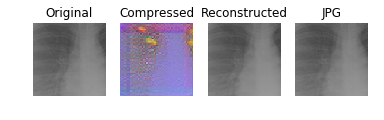

image11 reconstruction PSNR: 35.386173682273125
image11 jpeg PSNR: 46.47695189366557
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


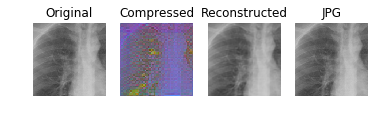

image12 reconstruction PSNR: 34.19770282207283
image12 jpeg PSNR: 43.71605200946536
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


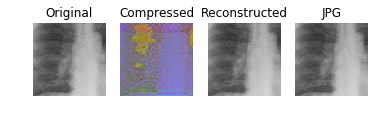

image13 reconstruction PSNR: 34.0201589832855
image13 jpeg PSNR: 42.95831662032768
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


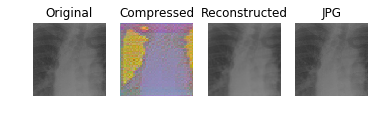

image14 reconstruction PSNR: 35.37233028546328
image14 jpeg PSNR: 46.470501635464146
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


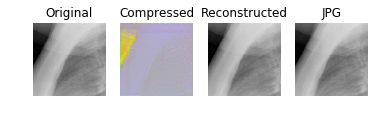

image15 reconstruction PSNR: 35.21389544860836
image15 jpeg PSNR: 45.743694971014214
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


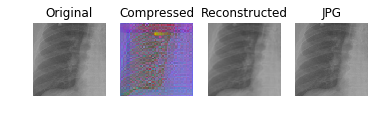

image16 reconstruction PSNR: 35.298674564246504
image16 jpeg PSNR: 44.34664421463937
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


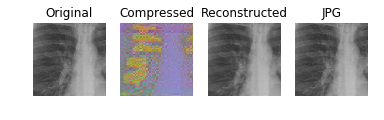

image17 reconstruction PSNR: 33.60127327044336
image17 jpeg PSNR: 42.04837930507905
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


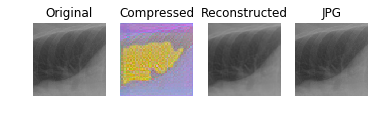

image18 reconstruction PSNR: 36.27434236551147
image18 jpeg PSNR: 46.346069870816834
(200, 200, 3)
(50, 50, 3)
(200, 200, 3)
(200, 200, 3)


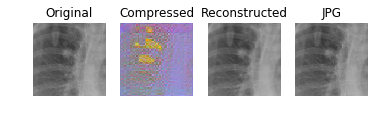

image19 reconstruction PSNR: 34.12935996410718
image19 jpeg PSNR: 43.704281414978624

Average reconstruction PSNR: 34.11893343730942
Average JPEG PSNR: 44.07353628912048

hello
iterating through dataset
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


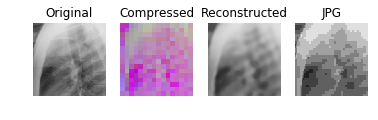

image0 reconstruction PSNR: 26.44050622635083
image0 jpeg PSNR: 22.30782306432416
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


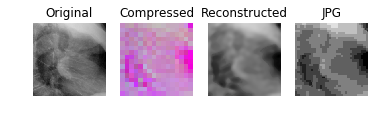

image1 reconstruction PSNR: 25.484238691223272
image1 jpeg PSNR: 22.00889006508455
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


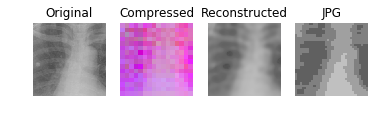

image2 reconstruction PSNR: 29.024972082892432
image2 jpeg PSNR: 23.281226579403427
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


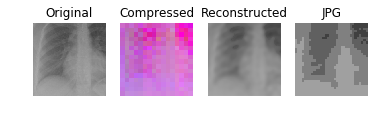

image3 reconstruction PSNR: 30.24511734893175
image3 jpeg PSNR: 23.52619213397778
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


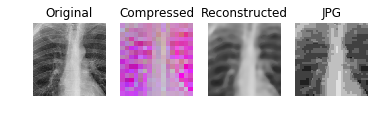

image4 reconstruction PSNR: 23.744123675347517
image4 jpeg PSNR: 20.768053604787184
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


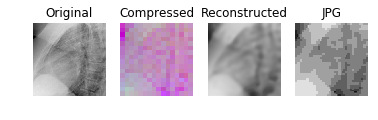

image5 reconstruction PSNR: 25.3081893990081
image5 jpeg PSNR: 21.760505066236057
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


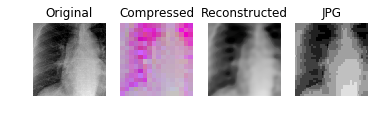

image6 reconstruction PSNR: 25.28757627174309
image6 jpeg PSNR: 21.689657485838374
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


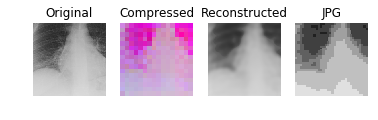

image7 reconstruction PSNR: 27.995740167705318
image7 jpeg PSNR: 22.23816154886363
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


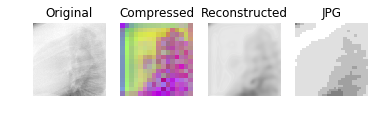

image8 reconstruction PSNR: 25.46426205179509
image8 jpeg PSNR: 23.329422735264295
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


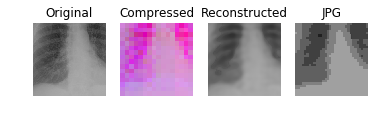

image9 reconstruction PSNR: 29.221822441958295
image9 jpeg PSNR: 23.50843694578954
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


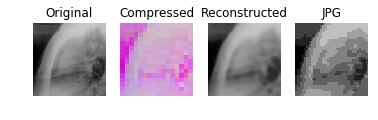

image10 reconstruction PSNR: 27.191459823823116
image10 jpeg PSNR: 22.477609589460265
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


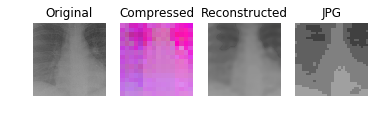

image11 reconstruction PSNR: 30.896452885939823
image11 jpeg PSNR: 22.892970294837358
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


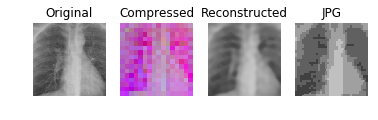

image12 reconstruction PSNR: 26.88952162213255
image12 jpeg PSNR: 22.259240325150778
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


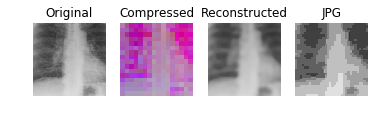

image13 reconstruction PSNR: 27.763426393713083
image13 jpeg PSNR: 22.210666548092014
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


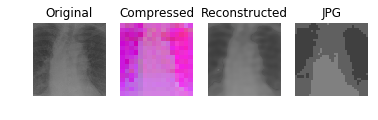

image14 reconstruction PSNR: 30.11577001063089
image14 jpeg PSNR: 24.00855510261313
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


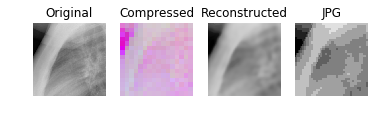

image15 reconstruction PSNR: 29.20845235228957
image15 jpeg PSNR: 22.77077183172913
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


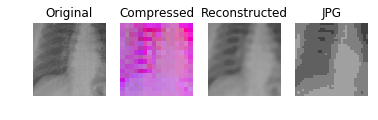

image16 reconstruction PSNR: 29.462681023464018
image16 jpeg PSNR: 23.375770576266397
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


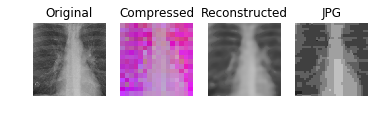

image17 reconstruction PSNR: 26.19936267225276
image17 jpeg PSNR: 21.989807291906438
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


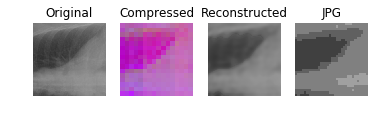

image18 reconstruction PSNR: 30.541409547153275
image18 jpeg PSNR: 23.861757257540987
(256, 256, 3)
(16, 16, 3)
(256, 256, 3)
(256, 256, 3)


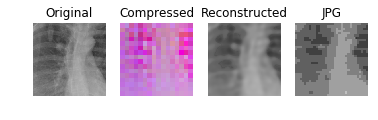

image19 reconstruction PSNR: 27.797910935865104
image19 jpeg PSNR: 22.536764281436756

Average reconstruction PSNR: 27.714149781210995
Average JPEG PSNR: 22.640114116430116



In [12]:
visualize(xray_loader,model100,"results/xray/100",100)
all_images = [[],[],[],[]]
visualize(xray_loader,model50,"results/xray/50",95)
all_images = [[],[],[],[]]
visualize(xray_loader256,model16.module,"results/xray/16",1)
